This code is written to make raw data to show the prediction of both large and small events.

In [1]:
# loading libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.font_manager as fm
from scipy.interpolate import interp1d
import sys
sys.path.append('./..')
from ProcessFunctions import ReadData,Find_T_X_tau_without_p_input
import pandas as pd
import cte
sys.path.append('/central/groups/astuart/hkaveh/QDYN/qdyn-read-only/src')  # For pyqdyn
import joblib
from pyqdyn import qdyn
import cte_eq
from scipy import integrate


  

In [2]:
# These are the variables that I am using here
# slip rate and theta nonuniform (in time) from qdyn are named V_ox and theta_ox, the time of the qdyn simulation is also t_ox
# V_ox_uniform and stress_ox_uniform are the uniform (in time) slip rate and stress from qdyn
# The observed slip rate is called V_ox_ROM_obs which is corrupted by noise and a low pass filter
# time_inversion is the time asscoiated with the inversion time series. It starts with 0. 
# start_time is the time when we start the data assimilation algorithm.
# V_ox_ROM_inverted and theta_ox_ROM_inverted are the inverted slip rate and theta uniform (in time) from the data assimilation algorithm


In [3]:
N_m_v_list=[20,25,30]
N_m_theta_list=[20,25,30]
index=0
PlotSmallEvents=False
Obs_linear=0
N_t=400000 
m=80
sigma_kernel=2000 # in meters
gamma_ratio=0.0001
N_m_v=N_m_v_list[index]
N_m_theta=N_m_theta_list[index]
dt=6*3600
# I commented These becasue I dont know if I will need to use these.

# L=cte.L_asp+cte.L_buffer  
# Nx=256
# Nw=32
# W=cte.W  
# t_yr=cte.t_yr
# cmap="jet"
# size_x=256
# size_y=32
# size=size_x*size_y
# L_thresh=1e3 # to define an event
# V_thresh=(5e-8) # to define an event
# L_fault=L
# mu=30e9
version=0

In [4]:
# QDYN: importing the data that is being using for the inversion (True data)
T_final_run = 350 # each initial condition is simulated for 250 years
Nt=5     # it is recorded every Nt time stes
N_m_v=20 # number of modes that they have considered
N_m_theta=20 # number of modes that they have considered
coeff=1 # How the inital conditions are from the chaotic attractor
number=102 # Which one do you want to load
N_m_load=30
filter_ratio = 0.2
## 
# loading raw data
data_dir='/central/groups/Avouac_lab/hkaveh/Data/LearnROM/2D/SampleSimulation_Tf_2D'+str(T_final_run)+"Nt="+str(cte_eq.Ntout)+"N_m"+str(N_m_load)+"coeff"+str(coeff)+"number"+str(number)+".npz"
data_smaple=np.load(data_dir)
V_ox=data_smaple['array1']
theta_ox=data_smaple['array2']
t_ox=data_smaple['array3']
Start_index=int(V_ox.shape[0]*filter_ratio)
start_time=t_ox[Start_index,0]/cte.t_yr


In [5]:
start_time

78.3462647974144

In [6]:
T_final=10500
Ntout=cte_eq.Ntout
Nxout=cte_eq.Nxout
drs=0.012
mu=3e10

# loading POD modes for v and theta
data_dir='/central/groups/Avouac_lab/hkaveh/Data/LearnROM/2D/MainSimulation2D_Tf'+str(T_final)+"Nt="+str(Ntout)+"Nx="+str(Nxout)+'PODonlyonV'+'drs'+str(drs)+".npz"
PODmodes=np.load(data_dir)
U_v=PODmodes['U']
S_v=PODmodes['S']
# VT_v=PODmodes['VT']
q_bar_v=PODmodes['q_bar']
Sigma_v=np.diagonal(S_v)
Nt2=127534 # This is the number os snapshots used to find the POD, it is fined in the RunForward2D.ipynb
Lambda_v=Sigma_v**2/Nt2 # Covariance matrix
size_x=U_v.shape[0]


data_dir='/central/groups/Avouac_lab/hkaveh/Data/LearnROM/2D/MainSimulation2D_Tf'+str(T_final)+"Nt="+str(Ntout)+"Nx="+str(Nxout)+'PODonlyontheta'+'drs'+str(drs)+".npz"
PODmodes=np.load(data_dir)
U_theta=PODmodes['U']
S_theta=PODmodes['S']
# VT_theta=PODmodes['VT']
q_bar_theta=PODmodes['q_bar']
Sigma_theta=np.diagonal(S_theta)
# Nt2=VT_theta.shape[0]
Lambda_theta=Sigma_theta**2/Nt2 # Covariance matrix
N_m_load=30
phi=U_v[:,:N_m_load]    # This contains the eigen mode for velocity



In [7]:
# INVERSION: importing the inversion results



data=np.load("/central/groups/Avouac_lab/hkaveh/Data/LearnROM/2D/EnKF_N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+"Obs_linear"+str(Obs_linear)+"N_t"+str(N_t)+"m"+str(m)+"sigma_kernel"+str(sigma_kernel)+"gamma_ratio"+str(gamma_ratio)+"version"+str(version)+"NumberinDataset"+str(number)+".npz")
alpha_a=data['alpha_a']
alpha_f=data['alpha_f']
Innovations=data['Innovations']
time_inversion=data['time']
y_obs=data['y_obs']
X_uniform=data['X_uniform']
t_0_inversion=data['t_0']
theta_data=X_uniform[:,N_m_v:].T
end_time=time_inversion[-1]/cte.t_yr

In [8]:
print(start_time,t_0_inversion/cte.t_yr)


78.3462647974144 [78.3462648]


In [9]:
time_inversion[-1]/dt

400000.0

In [10]:
alpha_a.shape

(40, 80, 400000)

In [11]:
y_obs.shape


(20, 400000)

In [12]:
# Changing y_obs into time seris of observed slip rate
U_ROM_V=U_v[:,0:N_m_v_list[index]]
V_ox_ROM_obs=np.zeros((y_obs.shape[1],size_x))
for j in range(y_obs.shape[1]):
    V_snapshot = U_ROM_V @ y_obs[:,j]+ q_bar_v.reshape(size_x,)
    V_snapshot = V_snapshot[:size_x].reshape(size_x)
    V_ox_ROM_obs[j,:]=10**(V_snapshot)



In [13]:
alpha_a.shape

(40, 80, 400000)

In [14]:
# Changing alpha_a into time seris of inverted slip rate

V_ox_ROM_inverted=np.zeros((alpha_a.shape[2],size_x))
ave_alpha=np.mean(alpha_a,axis=1)
ave_alpha_v=ave_alpha[0:N_m_v_list[index],:]


for j in range(ave_alpha_v.shape[1]):
    V_snapshot = U_ROM_V @ ave_alpha_v[:,j]+ q_bar_v.reshape(size_x,)
    V_snapshot = V_snapshot[:size_x ].reshape(size_x)
    V_ox_ROM_inverted[j,:]=10**(V_snapshot)

In [15]:
U_ROM_theta=U_theta[:,0:N_m_theta_list[index]] # picking the first N_m_theta modes
theta_ox_ROM_inverted=np.zeros((alpha_a.shape[2],size_x)) # initializing the inverted theta
ave_alpha_theta=ave_alpha[N_m_v_list[index]:,:] # picking the inverted theta
for j in range(ave_alpha_theta.shape[1]): # looping over the time steps
    theta_snapshot = U_ROM_theta @ ave_alpha_theta[:,j]+ q_bar_theta.reshape(size_x,) # reconstructing the theta
    theta_snapshot = theta_snapshot[:size_x].reshape( size_x)
    theta_ox_ROM_inverted[j,:]=10**(theta_snapshot)

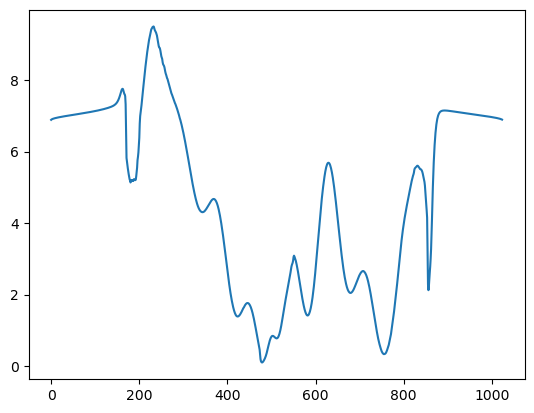

In [16]:
plt.plot(np.log10(theta_ox_ROM_inverted[1000,:]))

In [17]:
# I dont need this part yet. I dont want to find the stress on the fault yet.
# # loading the dictinary of a,b,drs,f0,v0,sigma
# mesh_dict=np.load("/central/groups/astuart/hkaveh/Data/LearnROM/meshdict.npz")
# a_array=mesh_dict['a']
# b_array=mesh_dict['b']
# drs_array=mesh_dict['drs']
# f0=mesh_dict['f0']
# v0=mesh_dict['V0']
# sigma=mesh_dict['sigma']
# def findstress(v,theta):
#     stress=sigma*(f0+a_array*np.log(v/v0)+b_array*np.log(v0*theta/drs_array))
#     return stress


In [18]:
time_inversion.shape

(400000,)

In [19]:
(time_inversion+t_0_inversion)[-1]/cte.t_yr

352.1388395427873

In [20]:
t_ox[-1,0]/cte.t_yr

350.0095827401161

In [21]:
# Note that V_ox is with nonuniform time stepping. To subtract from the analysis step, we need to interpolate it to the uniform time stepping
# The unifor time is called time_inversion
# the nonuniform time is called t_ox
# we call the uniformed V_ox as V_ox_uniform

V_ox_uniform=np.zeros((len(time_inversion),size_x))

for j in range(size_x):
    f = interp1d(t_ox[:,j], V_ox[:,j], kind='linear',fill_value='extrapolate')
    V_ox_uniform[:,j]=f(time_inversion+t_0_inversion)



In [22]:
V_ox_uniform.shape

(400000, 1024)

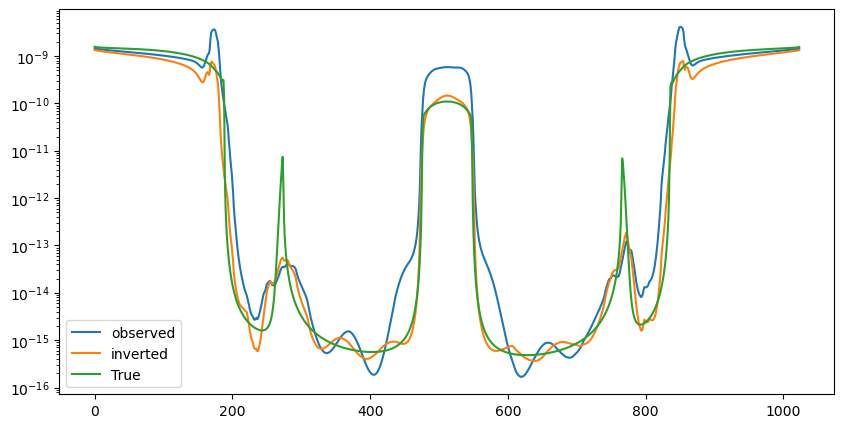

In [23]:
# plotting two figures
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])
iteration_to_plot=100000
# plot the ROM, Observation and error
ax0.plot(V_ox_ROM_obs[iteration_to_plot,:],label='observed')
ax0.plot(V_ox_ROM_inverted[iteration_to_plot,:],label="inverted")
ax0.plot(V_ox_uniform[iteration_to_plot,:],label="True")
ax0.set_yscale("log")
ax0.legend()

In [24]:
# # plotting Slip Rate
# #,vmin=np.log10(V_thresh_min),vmax=np.log10(V_thresh_max)
# xlimleft=20
# xlimright=50
# fig = plt.figure(figsize=(7.7, 14))
# serif_font = fm.FontProperties(family="serif", size=8)
# # Use serif font and set font size for all text in the figure
# plt.rc('font', family='serif')
# plt.rcParams.update({'font.family': 'serif'})
# plt.rcParams.update({'font.size': 8})
# gs = gridspec.GridSpec(nrows=11, ncols=2,width_ratios=[1,.03]) 

# axes1 = fig.add_subplot(gs[0, 0]) # True slip rate 
# axes2 = fig.add_subplot(gs[1, 0]) # observed slip rate
# axes3 = fig.add_subplot(gs[2, 0]) # estimated slip rate
# axes4 = fig.add_subplot(gs[3, 0]) # Error in slip rate
# axes5 = fig.add_subplot(gs[4, 0]) # Error in slip rate
# axes6 = fig.add_subplot(gs[5, 0]) # Error in slip rate
# axes7 = fig.add_subplot(gs[6, 0]) # Error in slip rate
# axes8 = fig.add_subplot(gs[7, 0]) # Error in slip rate
# axes9 = fig.add_subplot(gs[8, 0]) # observed stress
# axes10 = fig.add_subplot(gs[9, 0]) # inverted stress
# axes11 = fig.add_subplot(gs[10, 0]) # inverted stress

# cax1 = fig.add_subplot(gs[0, 1])  
# cax2 = fig.add_subplot(gs[1, 1])  
# cax3 = fig.add_subplot(gs[2, 1])  
# cax4 = fig.add_subplot(gs[3, 1])
# cax5 = fig.add_subplot(gs[4, 1])
# cax6 = fig.add_subplot(gs[5, 1])
# cax7 = fig.add_subplot(gs[6, 1])
# cax8 = fig.add_subplot(gs[7, 1])
# cax9 = fig.add_subplot(gs[8, 1])
# cax10 = fig.add_subplot(gs[9, 1])
# cax11 = fig.add_subplot(gs[10, 1])

# # axes1 
# V_thresh_min=1e-9
# V_thresh_max=1e-6   
# x_ox=np.linspace(-L/2,L/2,Nx)
# V_dip_mean=np.max(V_ox,axis=1).T   # Mean Velocity along the dip
# Nt=t_ox.shape[0]
# x_ox_t=np.vstack([x_ox]*Nt).T # what?
# time=np.max(t_ox,axis=1).T # what? simply getting rid of the axis 1 because axis 0 and 1 have the same value for time  
# PrettyTime=np.reshape(time.T,-1)
# Prettyx=np.reshape(x_ox_t.T,-1)
# PrettyV=np.reshape(V_dip_mean.T,-1)
    
# pl=axes1.scatter(PrettyTime/t_yr-start_time,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1)  
# axes1.set_xlabel(r'Time (year)',fontproperties=serif_font)
# axes1.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
# axes1.set_xlim(left=xlimleft,right=xlimright)
# axes1.set_title(r'True Slip Rate from QDYN without noise',fontproperties=serif_font)
# b=fig.colorbar(pl,cax=cax1)
# b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
# axes1.set_ylim(bottom=-150,top=150)

# # axes 2 
# Nt=y_obs.shape[1]
# x_ox_t=np.vstack([x_ox]*Nt).T 
# time = np.tile(time_inversion, (256, 1))
# PrettyTime=np.reshape(time.T,-1)
# Prettyx=np.reshape(x_ox_t.T,-1)
# V_dip_mean=np.max(V_ox_ROM_obs,axis=1).T   # Mean Velocity along the dip
# PrettyV=np.reshape(V_dip_mean.T,-1)

# pl=axes2.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1)  
# axes2.set_xlabel(r'Time (year)',fontproperties=serif_font)
# axes2.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
# axes2.set_xlim(left=xlimleft,right=xlimright)
# axes2.set_title(r'Observed Slip Rate from QDYN with noise and low pass filter',fontproperties=serif_font)
# b=fig.colorbar(pl,cax=cax2)
# b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
# axes2.set_ylim(bottom=-150,top=150)

# # axes 3
# Nt=ave_alpha_v.shape[1]
# x_ox_t=np.vstack([x_ox]*Nt).T
# time = np.tile(time_inversion, (256, 1))
# PrettyTime=np.reshape(time.T,-1)
# Prettyx=np.reshape(x_ox_t.T,-1)
# V_dip_mean=np.max(V_ox_ROM_inverted,axis=1).T   # Mean Velocity along the dip
# PrettyV=np.reshape(V_dip_mean.T,-1)

# pl=axes3.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1)
# axes3.set_xlabel(r'Time (year)',fontproperties=serif_font)
# axes3.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
# axes3.set_title(r'Estimated Slip Rate from Data Assimilation Algorithm',fontproperties=serif_font)
# axes3.set_xlim(left=xlimleft,right=xlimright)
# b=fig.colorbar(pl,cax=cax3)
# b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
# axes3.set_ylim(bottom=-150,top=150)

# # axes 4

# Nt=y_obs.shape[1]
# x_ox_t=np.vstack([x_ox]*Nt).T 
# time = np.tile(time_inversion, (256, 1))
# PrettyTime=np.reshape(time.T,-1)
# Prettyx=np.reshape(x_ox_t.T,-1)
# Error=np.abs(V_ox_ROM_obs-V_ox_uniform)
# V_dip_mean=np.max(Error,axis=1).T   # Mean Velocity along the dip
# PrettyV=np.reshape(V_dip_mean.T,-1)

# pl=axes4.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1)  
# axes4.set_xlabel(r'Time (year)',fontproperties=serif_font)
# axes4.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
# axes4.set_title(r'Added error in observation process',fontproperties=serif_font)
# axes4.set_xlim(left=xlimleft,right=xlimright)
# b=fig.colorbar(pl,cax=cax4)
# b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
# axes4.set_ylim(bottom=-150,top=150)

# # axes 5

# Nt=ave_alpha_v.shape[1]
# x_ox_t=np.vstack([x_ox]*Nt).T
# time = np.tile(time_inversion, (256, 1))
# PrettyTime=np.reshape(time.T,-1)
# Prettyx=np.reshape(x_ox_t.T,-1)
# Error=np.abs(V_ox_ROM_inverted-V_ox_uniform)


# V_dip_mean=np.max(Error,axis=1).T   # Mean Velocity along the dip
# PrettyV=np.reshape(V_dip_mean.T,-1)

# pl=axes5.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1)
# axes5.set_xlabel(r'Time (year)',fontproperties=serif_font)
# axes5.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
# axes5.set_xlim(left=xlimleft,right=xlimright)
# axes5.set_title(r'Error in the estimated slip rate',fontproperties=serif_font)  
# b=fig.colorbar(pl,cax=cax5)
# b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
# axes5.set_ylim(bottom=-150,top=150)


# # axes 6

# Nt=ave_alpha_v.shape[1]
# x_ox_t=np.vstack([x_ox]*Nt).T
# time = np.tile(time_inversion, (256, 1))
# PrettyTime=np.reshape(time.T,-1)
# Prettyx=np.reshape(x_ox_t.T,-1)
# Error=np.abs(V_ox_ROM_inverted-V_ox_ROM_obs)


# V_dip_mean=np.max(Error,axis=1).T   # Mean Velocity along the dip
# PrettyV=np.reshape(V_dip_mean.T,-1)

# pl=axes6.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1)
# axes6.set_xlabel(r'Time (year)',fontproperties=serif_font)
# axes6.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
# axes6.set_title(r'Difference between inversion and observation',fontproperties=serif_font)
# axes6.set_xlim(left=xlimleft,right=xlimright)
# b=fig.colorbar(pl,cax=cax6)
# b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
# axes6.set_ylim(bottom=-150,top=150)

# # axes 7

# Nt=ave_alpha_v.shape[1]
# x_ox_t=np.vstack([x_ox]*Nt).T
# time = np.tile(time_inversion, (256, 1))
# PrettyTime=np.reshape(time.T,-1)
# Prettyx=np.reshape(x_ox_t.T,-1)

# V_dip_mean=np.max(V_ox_uniform,axis=1).T   # Mean Velocity along the dip
# PrettyV=np.reshape(V_dip_mean.T,-1)

# pl=axes7.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1)
# axes7.set_xlabel(r'Time (year)',fontproperties=serif_font)
# axes7.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
# axes7.set_xlim(left=xlimleft,right=xlimright)
# axes7.set_title(r'Uniform Slip Rate from QDYN without noise (same as fig1 but interpolated in time)',fontproperties=serif_font)
# b=fig.colorbar(pl,cax=cax7)
# b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
# axes7.set_ylim(bottom=-150,top=150)


# # axes 8

# Nt=ave_alpha_v.shape[1]
# x_ox_t=np.vstack([x_ox]*Nt).T
# time = np.tile(time_inversion, (256, 1))
# PrettyTime=np.reshape(time.T,-1)
# Prettyx=np.reshape(x_ox_t.T,-1)
# Error=np.abs(V_ox_ROM_inverted-V_ox_uniform)
# V_dip_mean=np.mean(Error,axis=1).T   # Mean Velocity along the dip
# PrettyV=np.reshape(V_dip_mean.T,-1)

# pl=axes8.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1)
# axes8.set_xlabel(r'Time (year)',fontproperties=serif_font)
# axes8.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
# axes8.set_xlim(left=xlimleft,right=xlimright)
# axes8.set_title(r'Error in the estimated slip rate, difference between estimated and true slip rate',fontproperties=serif_font)
# b=fig.colorbar(pl,cax=cax8)
# b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
# axes8.set_ylim(bottom=-150,top=150)

# # axes 9

# Nt=y_obs.shape[1]
# x_ox_t=np.vstack([x_ox]*Nt).T
# time = np.tile(time_inversion, (256, 1))
# PrettyTime=np.reshape(time.T,-1)
# Prettyx=np.reshape(x_ox_t.T,-1)
# V_dip_mean=np.max(stress_ox_uniform,axis=1).T   # Mean Velocity along the dip
# PrettyV=np.reshape(V_dip_mean.T,-1)

# pl=axes9.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=(PrettyV),cmap=cmap,linewidths=1)
# axes9.set_xlabel(r'Time (year)',fontproperties=serif_font)
# axes9.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
# axes9.set_xlim(left=xlimleft,right=xlimright)
# axes9.set_title(r'True Stress from QDYN without noise',fontproperties=serif_font)
# b=fig.colorbar(pl,cax=cax9)
# b.set_label(label=r'$\sigma$',fontproperties=serif_font)
# axes9.set_ylim(bottom=-150,top=150)

# # axes 10

# Nt=ave_alpha_v.shape[1]
# x_ox_t=np.vstack([x_ox]*Nt).T
# time = np.tile(time_inversion, (256, 1))
# PrettyTime=np.reshape(time.T,-1)
# Prettyx=np.reshape(x_ox_t.T,-1)
# V_dip_mean=np.max(stress_inverted,axis=1).T   # Mean Velocity along the dip
# PrettyV=np.reshape(V_dip_mean.T,-1)

# pl=axes10.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=(PrettyV),cmap=cmap,linewidths=1)
# axes10.set_xlabel(r'Time (year)',fontproperties=serif_font)
# axes10.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
# axes10.set_xlim(left=xlimleft,right=xlimright)
# axes10.set_title(r'Estimated Stress from Data Assimilation Algorithm',fontproperties=serif_font)
# b=fig.colorbar(pl,cax=cax10)
# b.set_label(label=r'$\sigma$',fontproperties=serif_font)
# axes10.set_ylim(bottom=-150,top=150)


# # axes 11

# Nt=ave_alpha_v.shape[1]
# x_ox_t=np.vstack([x_ox]*Nt).T
# time = np.tile(time_inversion, (256, 1))
# PrettyTime=np.reshape(time.T,-1)
# Prettyx=np.reshape(x_ox_t.T,-1)
# V_dip_mean=np.max(stress_inverted-stress_ox_uniform,axis=1).T   # Mean Velocity along the dip
# PrettyV=np.reshape(V_dip_mean.T,-1)

# pl=axes11.scatter(PrettyTime/t_yr,Prettyx*1e-3,marker=".",c=(PrettyV),cmap=cmap,linewidths=1)
# axes11.set_xlabel(r'Time (year)',fontproperties=serif_font)
# axes11.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
# axes11.set_xlim(left=xlimleft,right=xlimright)
# axes11.set_title(r'Error in stress estimation',fontproperties=serif_font)
# b=fig.colorbar(pl,cax=cax11)
# b.set_label(label=r'$\sigma$',fontproperties=serif_font)
# axes11.set_ylim(bottom=-150,top=150)
# plt.tight_layout()
# plt.show()



In [25]:
ave_alpha_v.shape


(20, 400000)

In [26]:
# finding the magnitude of events
def findscalingquantities(pdot,t,v,delta_x,V_event=1e-2): 
    flag_event=False
    T1s=[] # this is the time of the start of events
    T2s=[] # this is the time of the end of events
    length_ruptures=[] # this is the length of the rupture
    pots=[] # integral of pdot over the event duration
    for i in range(v.shape[0]): # first dimension is time
        if np.max(v[i,:])>V_event and flag_event==False:
            start=i
            T1s.append(t[i,0])
            flag_event=True
            print(i)
        if np.max(v[i,:])<V_event and flag_event==True:
            end=i
            flag_event=False
            T2s.append(t[i,0])
            print(i)
            # check from start to end for all elements of v[start,:] to v[end,:] which elements had v >v_event in one line, from this you can find the event extent
            ruptured=np.where(v[start:end,:]>V_event,1,0)
            # find the locations at which at least there is one element that is ruptured
            ruptured=np.sum(ruptured,axis=0)
            ruptured=(ruptured>0)
            # summing number of ruptured elements
            num_ruptured_elements=np.sum(ruptured)
            # then the rupture length of this event is given by 
            length_rupture=num_ruptured_elements*delta_x
            length_ruptures.append(length_rupture)
            potency_of_event=integrate.cumtrapz(pdot[start:end+1],t[start:end+1,0])    
            pots.append(potency_of_event[-1])
    return  T1s,T2s,length_ruptures,pots

In [27]:
def Gut(Mw,NpointsM=30):
    CumNumber=np.array([])
    c1=np.min(Mw)
    c2=np.max(Mw)-.0001 # To remove log10(0) error
    print(c1)
    print(c2)
    c=np.linspace(c1,c2,NpointsM)
    print(c)
    for i in range(c.size):
        CumNumber=np.append(CumNumber,(sum(j > c[i] for j in Mw)))
    return c,CumNumber  

In [28]:
L=240e3
delta_x=L/size_x
t=(time_inversion+t_0_inversion).reshape(N_t,1)


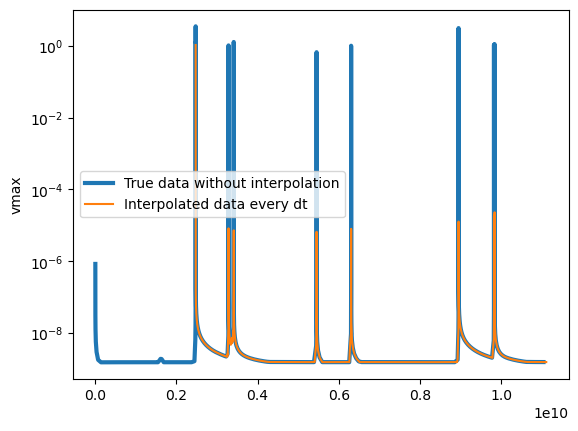

In [29]:
vmax_uniform=np.max(V_ox_uniform,axis=1)
vmax_nonuniform=np.max(V_ox,axis=1)

plt.plot(t_ox[:,0],vmax_nonuniform,linewidth=3,label="True data without interpolation")
plt.plot(t,vmax_uniform,label="Interpolated data every dt")
plt.legend()
plt.ylabel("vmax")
plt.yscale("log")


In [30]:
# removing the data before start of the event, finding events "magnitude" and time, we are interested in the initial condition before large events.
index_start=np.argmin(np.abs((t_ox[:,0]/cte.t_yr-start_time)))
t_ox_filtered=t_ox[index_start:,:]
V_ox_filtered=V_ox[index_start:,:]
pdot=np.sum(V_ox_filtered,axis=1)*delta_x

T1s,T2s,length_ruptures,pots=findscalingquantities(pdot,t_ox_filtered,V_ox_filtered,delta_x,V_event=1e-2)

T1s=np.array(T1s)
T2s=np.array(T2s)
length_ruptures=np.array(length_ruptures)
pots=np.array(pots)
moment_events=mu*pots
log_10_moment_events=np.log10(moment_events)
mags,cumN=Gut(log_10_moment_events)
mags_thresh=15.5
mask=log_10_moment_events>mags_thresh

TimeStarts_filtered = T1s[mask]
TimeEnds_filtered = T2s[mask]
Mags_filtered = log_10_moment_events[mask]


0
1528
1602
1825
1876
2140
2204
2322
2360
2598
2667
3850
3874
5136
5206
5406
5431
5631
14.451182724188337
16.633295597174165
[14.45118272 14.526428   14.60167327 14.67691854 14.75216381 14.82740908
 14.90265435 14.97789962 15.0531449  15.12839017 15.20363544 15.27888071
 15.35412598 15.42937125 15.50461652 15.5798618  15.65510707 15.73035234
 15.80559761 15.88084288 15.95608815 16.03133343 16.1065787  16.18182397
 16.25706924 16.33231451 16.40755978 16.48280505 16.55805033 16.6332956 ]


In [31]:
Mags_filtered

array([16.6333956 , 16.15067682, 16.50968328])

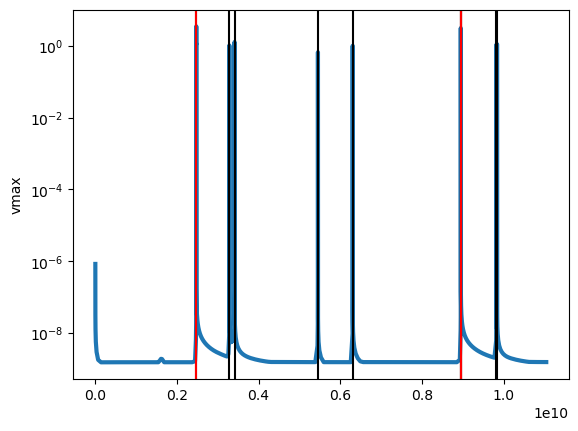

In [32]:
plt.plot(t_ox[:,0],vmax_nonuniform,linewidth=3)
plt.ylabel("vmax")
plt.yscale("log")
for index in range(len(T1s)):
    plt.axvline(T1s[index],color='black')
for index in range(len(TimeStarts_filtered)):
    plt.axvline(TimeStarts_filtered[index],color='red')


In [33]:
# import qdyn: done
sys.path.append('/central/groups/astuart/hkaveh/QDYN/qdyn-read-only/src')  # For pyqdyn
from pyqdyn import qdyn
# import parameters that are needed to run the forward model: done
# check that everything is properly imported: done
# define the parameters: done
# Now I want you to think about how you want to do the prediction.
# one way is to set tau. For each tau, you simulate the forward model from all [T_start - tau] up to probably 2\tau or 3\tau and plot the rupture extent
# you are predicting the magnitude and the time of the next event
# as someone who is working on earthquake forecast you need to comeup with good defenition of prediction quality



In [34]:
# you need to load the forward model, hopefully I have a code that I can use?
from Forward2d import forwardmodel


In [35]:
tau=2 * 24 * 3600 # 1 day predition head
T_run_forecast= 14 * 24 * 3600 # 1 day predition head
Specifyinit=True
drs=0.012


In [36]:
Ntout

50

In [37]:
Nxout

4

In [38]:
x_lowres=np.linspace(-cte_eq.L,cte_eq.L,size_x)
x_highres=np.linspace(-cte_eq.L,cte_eq.L,size_x*cte_eq.Nxout)


In [39]:
tau

172800

In [40]:
len(TimeStarts_filtered)

3

In [41]:
t_ox.shape

(7093, 1024)

In [42]:
T_run_forecast/24/3600

14.0

In [43]:
TimeStarts_filtered

array([2.47235239e+09, 8.95121002e+09, 8.95121066e+09])

283.65449512586156
299938
Number of elements 4096
 Number of processors =            1
 Start reading input ...
    Mesh input complete
   Flags input complete
 Input complete
 Initializing mesh ...
 1D fault, uniform grid
 Impedance =    4545454.5454545459     
 Intializing kernel: ...
 FFT applied
 Reading kernel /central/groups/astuart/hkaveh/QDYN/qdyn-read-only/src/kernel_I.tab
 Kernel intialized
 Values at selected point of the fault:
 K/Kc =   -4.7123889803846894E-002
 K/Kb =    1.1780972450961723E-002

     it,  dt (secs), time (yrs), v_max (m/s), sigma_max (MPa)
 Initialising RK45 solver
 Finished initialising RK45 solver
 Initialization completed
      0   0.000E+00   0.000E+00   0.120E-07   0.500E+02
     50   0.904E-09   0.344E-15   0.120E-07   0.500E+02
    100   0.635E-07   0.247E-13   0.365E-06   0.500E+02
    150   0.446E-05   0.173E-11   0.252E-04   0.500E+02
    200   0.313E-03   0.122E-09   0.174E-02   0.500E+02
    250   0.183E-01   0.839E-08   0.346E-01   0.500E+02


<Figure size 500x740 with 0 Axes>

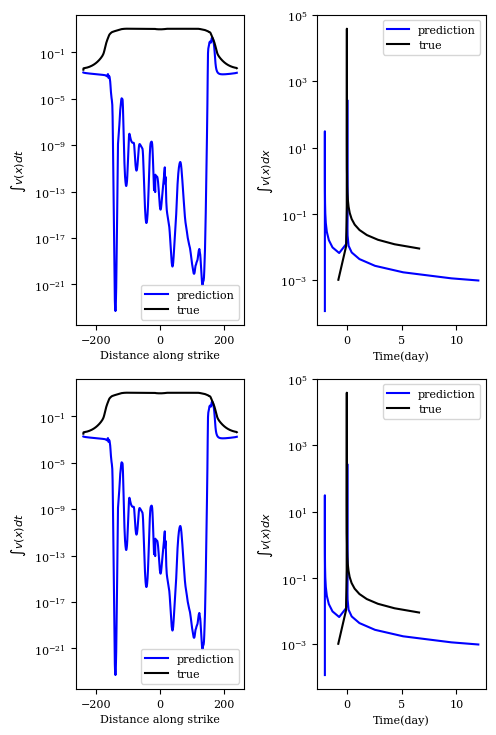

In [44]:
nrows=len(TimeStarts_filtered)-1
fig = plt.figure(figsize=(5, nrows*3.7))
fig = plt.figure(figsize=(5, nrows*3.7))
serif_font = fm.FontProperties(family="serif", size=8)
cmap='jet'
    # Use serif font and set font size for all text in the figure
plt.rc('font', family='serif')
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 8})

gs = gridspec.GridSpec(nrows=nrows, ncols=2,width_ratios=[1,1]) # I put 2 columns for now to wait to see how does the system look like for N_m=30



for i in range(1,len(TimeStarts_filtered)):
    # take the initial condition tau before the event start in the true data
    print(TimeStarts_filtered[i]/cte.t_yr)
    index=np.argmin(np.abs(TimeStarts_filtered[i]-tau-time_inversion-start_time*cte.t_yr)) # index in the inversion
    index=np.argmin(np.abs(TimeStarts_filtered[i]-tau-time_inversion-start_time*cte.t_yr)) # index in the inversion
    u_init=np.hstack([V_ox_ROM_inverted[index,:].ravel(),theta_ox_ROM_inverted[index,:].ravel()])
    u_init=np.log10(u_init)
    print(index)
    # making the data high resolution to run in the PDE.
    # TimeStarts_filtered is the time that we have exctracted from t_ox
    index_start_t_ox=np.argmin(np.abs(t_ox[:,0]-(TimeStarts_filtered[i]-tau)))
    index_end_t_ox=np.argmin(np.abs(t_ox[:,0]-(TimeStarts_filtered[i]-tau+T_run_forecast)))
    #%%

    v_interp = interp1d(x_lowres, u_init[:size_x].flatten(), kind='linear', fill_value="extrapolate")
    theta_interp = interp1d(x_lowres, u_init[size_x:].flatten(), kind='linear', fill_value="extrapolate")

    # Interpolated high-res fields
    v_init_highres = v_interp(x_highres).reshape(-1, 1)
    theta_init_highres = theta_interp(x_highres).reshape(-1, 1)
    # Combine into new u_init
    u_init_highres = np.vstack([v_init_highres, theta_init_highres])
    p=forwardmodel(T_run_forecast/cte.t_yr,Ntout,Nxout,Specifyinit,u_init_highres,drs)
    Nt = len(p.ox["v"]) // size_x
    V_ox_pred = p.ox["v"].values.reshape((Nt, size_x))
    t_ox_pred=p.ox["t"].values.reshape((Nt, size_x))
    ax_potency= fig.add_subplot(gs[i-1, 0]) # plot potency along strike for event i
    ax_potrate= fig.add_subplot(gs[i-1, 1]) # plot potency rate as a function of


    int_v = integrate.cumtrapz(V_ox_pred, x=t_ox_pred[:,0], axis=0)  # \integral v dt
    int_v_true=integrate.cumtrapz(V_ox[index_start_t_ox:index_end_t_ox,:],x=t_ox[index_start_t_ox:index_end_t_ox,0],axis=0)





    potencyrate=np.sum(V_ox_pred,axis=1)*delta_x # potency rate
    potencyrate_true=np.sum(V_ox[index_start_t_ox:index_end_t_ox,:],axis=1)*delta_x # potency rate



    ax_potency.plot(x_lowres/1e3,int_v[-1,:],label='prediction',color='blue')
    ax_potrate.plot((t_ox_pred[:,0]-tau)/(3600*24),potencyrate,label='prediction',color='blue')

    ax_potency.plot(x_lowres/1e3,int_v_true[-1,:],label='true',color='black')
    ax_potrate.plot((t_ox[index_start_t_ox:index_end_t_ox,0]-TimeStarts_filtered[i])/(3600*24),potencyrate_true,label='true',color='black')
    ax_potrate.set_xlabel('Time(day)')
    ax_potency.set_xlabel('Distance along strike')
    ax_potrate.set_ylabel(r'$\int v(x) dx$')
    ax_potency.set_ylabel(r'$\int v(x) dt$')
    ax_potency.set_yscale("log")
    ax_potrate.set_yscale("log")
    
    ax_potency.legend()
    ax_potrate.legend()
plt.tight_layout()


# saving the figure:
plt.savefig('/central/groups/astuart/hkaveh/Figs/ROM/prediction_eq'+str(number)+'.png',dpi=300,bbox_inches='tight')



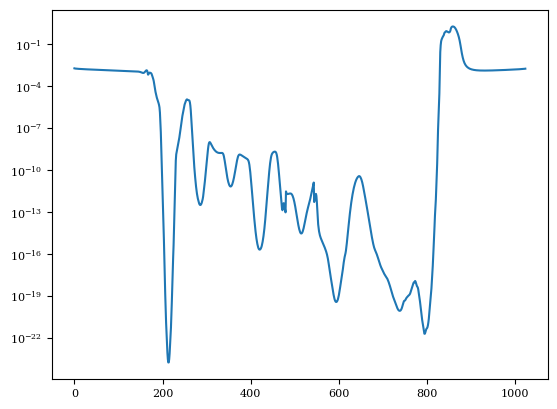

In [45]:
plt.plot(int_v[-1,:]-int_v[0,:])
plt.yscale('log')

In [46]:
index_end_t_ox

6573

In [47]:
(t_ox[index_end_t_ox+1,0]-t_ox[index_start_t_ox,0])/3600/24

15.208525616901893

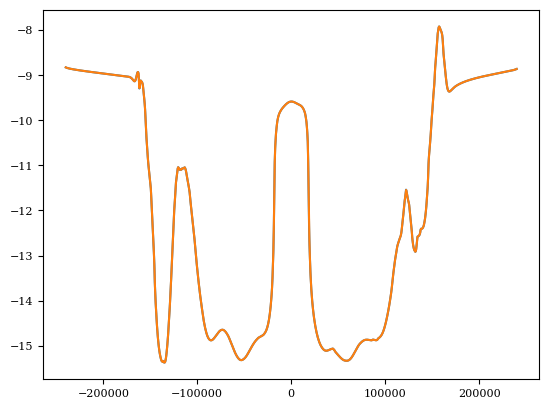

In [48]:
plt.plot(x_lowres,u_init[:size_x])
plt.plot(x_highres,v_init_highres)

In [49]:
vmax_pred=np.max(V_ox_pred,axis=1)

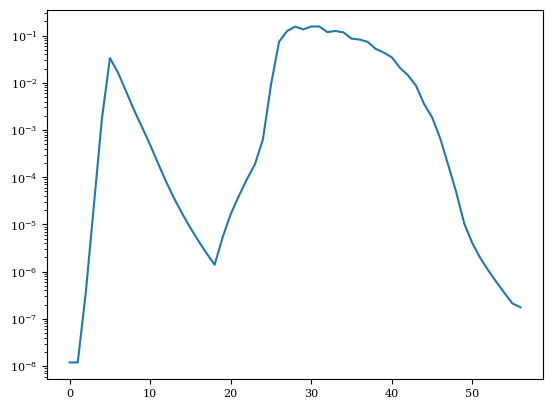

In [50]:
plt.plot(vmax_pred)
plt.yscale("log")

In [51]:
int_v.shape

(56, 1024)

In [52]:
number

102

In [53]:
x=t_ox_pred[:,0]
x.shape

(57,)

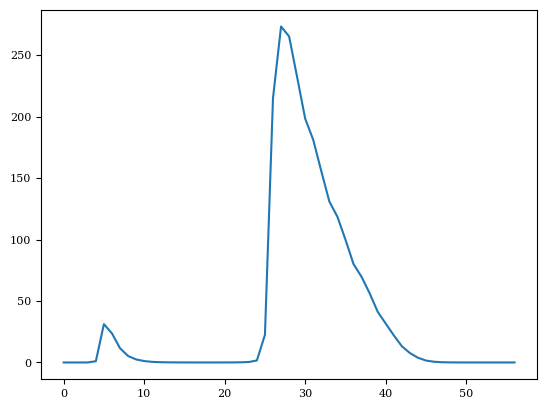

In [54]:
plt.plot(potencyrate)

In [55]:
index_end_t_ox

6573

Studying the false positve signal


In [56]:
# To check the false positive signal, I need to pick some times that is not between TimeStarts-T_final and TimeEnds. 
N_pick=20
T_final=T_run_forecast
restricted_intervals = [(start - T_final, end+T_final) for start, end in zip(TimeStarts_filtered, TimeEnds_filtered)]
# Function to check if a time is in a restricted period
def is_valid_time(t, restricted_intervals):
    return all(not (start <= t <= end) for start, end in restricted_intervals)

# Generate valid random times
valid_times = []
np.random.seed(42)
while len(valid_times) < N_pick:
    candidate = np.random.uniform(start_time*cte.t_yr, time_inversion[-1]-T_final)  # Generate a random time
    if is_valid_time(candidate, restricted_intervals):
        valid_times.append(candidate)

In [57]:
T_final

1209600

In [58]:
np.array(valid_times)/cte.t_yr

array([151.53439247, 264.12342601, 221.3837216 , 195.3289093 ,
       108.83355201, 108.82883875,  89.69626606, 247.60399489,
       195.80893438, 216.7092962 ,  82.36863923, 267.87438881,
       241.01219886, 119.83902128, 113.87631417, 114.18496941,
       137.79762662, 180.88785856, 162.75176792, 135.25476251])

151.5343924711134
106917
Number of elements 4096
 Number of processors =            1
 Start reading input ...
    Mesh input complete
   Flags input complete
 Input complete
 Initializing mesh ...
 1D fault, uniform grid
 Impedance =    4545454.5454545459     
 Intializing kernel: ...
 FFT applied
 Reading kernel /central/groups/astuart/hkaveh/QDYN/qdyn-read-only/src/kernel_I.tab
 Kernel intialized
 Values at selected point of the fault:
 K/Kc =   -4.7123889803846894E-002
 K/Kb =    1.1780972450961723E-002

     it,  dt (secs), time (yrs), v_max (m/s), sigma_max (MPa)
 Initialising RK45 solver
 Finished initialising RK45 solver
 Initialization completed
      0   0.000E+00   0.000E+00   0.133E-08   0.500E+02
     50   0.144E-01   0.547E-08   0.208E-08   0.500E+02
    100   0.101E+01   0.392E-06   0.928E-07   0.500E+02
    150   0.709E+02   0.276E-04   0.410E-05   0.500E+02
    200   0.521E+03   0.469E-03   0.224E-05   0.500E+02
    250   0.121E+04   0.178E-02   0.100E-05   0.500E+02
 

    700   0.133E+04   0.248E-02   0.159E-05   0.500E+02
    750   0.278E+04   0.562E-02   0.752E-06   0.500E+02
    800   0.550E+04   0.120E-01   0.377E-06   0.500E+02
    850   0.105E+05   0.244E-01   0.198E-06   0.500E+02
 RK45 error [8]: invalid input parameters
    884   0.127E+05   0.384E-01   0.133E-06   0.500E+02
0.00122275
82.36863922623678
5869
Number of elements 4096
 Number of processors =            1
 Start reading input ...
    Mesh input complete
   Flags input complete
 Input complete
 Initializing mesh ...
 1D fault, uniform grid
 Impedance =    4545454.5454545459     
 Intializing kernel: ...
 FFT applied
 Reading kernel /central/groups/astuart/hkaveh/QDYN/qdyn-read-only/src/kernel_I.tab
 Kernel intialized
 Values at selected point of the fault:
 K/Kc =   -4.7123889803846894E-002
 K/Kb =    1.1780972450961723E-002

     it,  dt (secs), time (yrs), v_max (m/s), sigma_max (MPa)
 Initialising RK45 solver
 Finished initialising RK45 solver
 Initialization completed
      

<Figure size 500x7400 with 0 Axes>

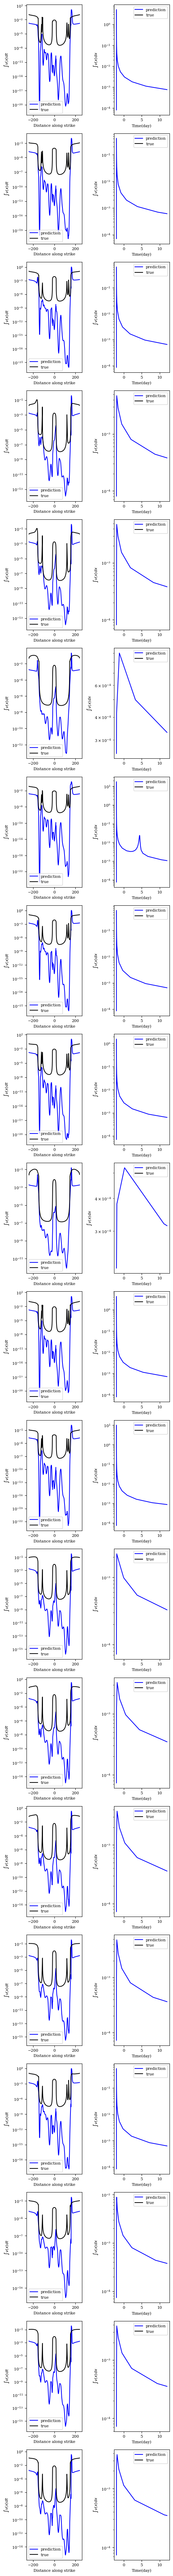

In [59]:
nrows=N_pick
fig = plt.figure(figsize=(5, nrows*3.7))
fig = plt.figure(figsize=(5, nrows*3.7))
serif_font = fm.FontProperties(family="serif", size=8)
cmap='jet'
    # Use serif font and set font size for all text in the figure
plt.rc('font', family='serif')
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 8})

gs = gridspec.GridSpec(nrows=nrows, ncols=2,width_ratios=[1,1]) # I put 2 columns for now to wait to see how does the system look like for N_m=30
count_false_signal=0


for i in range(N_pick):
    # take the initial condition tau before the event start in the true data
    print(valid_times[i]/cte.t_yr)
    index=np.argmin(np.abs(valid_times[i]-tau-time_inversion-start_time*cte.t_yr)) # index in the inversion
    u_init=np.hstack([V_ox_ROM_inverted[index,:].ravel(),theta_ox_ROM_inverted[index,:].ravel()])
    u_init=np.log10(u_init)
    print(index)
    # making the data high resolution to run in the PDE.
    # TimeStarts_filtered is the time that we have exctracted from t_ox
    index_start_t_ox=np.argmin(np.abs(t_ox[:,0]-(valid_times[i]-tau)))
    index_end_t_ox=np.argmin(np.abs(t_ox[:,0]-(valid_times[i]-tau+T_run_forecast)))
    #%%

    v_interp = interp1d(x_lowres, u_init[:size_x].flatten(), kind='linear', fill_value="extrapolate")
    theta_interp = interp1d(x_lowres, u_init[size_x:].flatten(), kind='linear', fill_value="extrapolate")

    # Interpolated high-res fields
    v_init_highres = v_interp(x_highres).reshape(-1, 1)
    theta_init_highres = theta_interp(x_highres).reshape(-1, 1)
    # Combine into new u_init
    u_init_highres = np.vstack([v_init_highres, theta_init_highres])
    p=forwardmodel(T_run_forecast/cte.t_yr,Ntout,Nxout,Specifyinit,u_init_highres,drs)
    Nt = len(p.ox["v"]) // size_x
    V_ox_pred = p.ox["v"].values.reshape((Nt, size_x))
    vmax=np.max(V_ox_pred)
    print(vmax)
    if vmax>1e-2:
        count_false_signal+=1
    t_ox_pred=p.ox["t"].values.reshape((Nt, size_x))
    ax_potency= fig.add_subplot(gs[i-1, 0]) # plot potency along strike for event i
    ax_potrate= fig.add_subplot(gs[i-1, 1]) # plot potency rate as a function of


    int_v = integrate.cumtrapz(V_ox_pred, x=t_ox_pred[:,0], axis=0)  # \integral v dt
    int_v_true=integrate.cumtrapz(V_ox[index_start_t_ox-1:index_end_t_ox+1,:],x=t_ox[index_start_t_ox-1:index_end_t_ox+1,0],axis=0)





    potencyrate=np.sum(V_ox_pred,axis=1)*delta_x # potency rate
    potencyrate_true=np.sum(V_ox[index_start_t_ox:index_end_t_ox,:],axis=1)*delta_x # potency rate



    ax_potency.plot(x_lowres/1e3,int_v[-1,:],label='prediction',color='blue')
    ax_potrate.plot((t_ox_pred[:,0]-tau)/(3600*24),potencyrate,label='prediction',color='blue')

    ax_potency.plot(x_lowres/1e3,int_v_true[-1,:],label='true',color='black')
    ax_potrate.plot((t_ox[index_start_t_ox:index_end_t_ox,0]-valid_times[i])/(3600*24),potencyrate_true,label='true',color='black')
    ax_potrate.set_xlabel('Time(day)')
    ax_potency.set_xlabel('Distance along strike')
    ax_potrate.set_ylabel(r'$\int v(x) dx$')
    ax_potency.set_ylabel(r'$\int v(x) dt$')
    ax_potency.set_yscale("log")
    ax_potrate.set_yscale("log")
    
    ax_potency.legend()
    ax_potrate.legend()
plt.tight_layout()


# saving the figure:
plt.savefig('/central/groups/astuart/hkaveh/Figs/ROM/prediction_FP_eq'+str(number)+'.png',dpi=300,bbox_inches='tight')



In [60]:
count_false_signal

1

In [61]:
print("ratio of false positive for number=101 is: 5 out of 20" )

ratio of false positive for number=101 is: 5 out of 20


In [62]:
print("ratio of false positive for number=102 is: 1 out of 20" )

ratio of false positive for number=102 is:


In [63]:
print("ratio of false positive for number=103 is: 4 out of 20" )

ratio of false positive for number=103 is: 4 out of 20


In [66]:
print("total FP ratio is: "+str(1/6))

total FP ratio is: 0.16666666666666666


In [64]:
# Concusion for the project for earthquake:
# The spatial prediction is not successfull out most of them I dont get near close the correct extend.
# The predicting if an event happens works good but the False Positive signal is high.
